In [47]:
from collections import namedtuple
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as random

In [2]:
wealth_record = []
starting_wealth = 100.0
interest_factor = 1.01
num_timesteps = 100
prev_wealth = starting_wealth

In [3]:
def wealth_at_time(prev_wealth, time, interest_factor):
    new_wealth = prev_wealth * interest_factor
    prev_wealth = new_wealth

    return prev_wealth, prev_wealth

In [4]:
wealth_func = partial(wealth_at_time, interest_factor=interest_factor)
timesteps = jnp.arange(num_timesteps)
final, result = jax.lax.scan(wealth_func, init=starting_wealth, xs=timesteps)

In [ ]:
plt.figure(figsize=(6, 2))
plt.plot(result, label="lax.scan")
plt.legend();

In [6]:
weights = [
    158.0, 164.2, 160.3, 159.9, 162.1, 164.6,
    169.6, 167.4, 166.4, 171.0, 171.2, 172.6
]

In [7]:
def cumsum(res, el):
    """
    - `res`: The result from the previous loop.
    - `el`: The current array element.
    """
    res = res + el # cumsum operation
    return res, res  # ("carryover", "accumulated")

result_init = 0.

final, result = jax.lax.scan(
    cumsum, result_init, jnp.array(weights)
)

In [26]:
data = jnp.array(weights)
x0 = 160.
dx = 1.
g = 6/10.
h = 2/3
dt = 1

In [79]:
filter_params = namedtuple("filter_params", ["x", "dx", "g", "h", "dt"])
filter_params = filter_params(x=160., dx=1., g=6./10, h=2./3, dt=1.)

In [80]:
def gh_filter(init, measurement):
    
    def compute(carry, y):
        x, dx = carry
        x_est = x + (dx * init.dt)
        residual = y - x_est
        dx = dx + init.h * residual
        x = x_est + init.g * residual

        return (x, dx), (x, dx)

    _, (xs, dxs) = jax.lax.scan(compute, (init.x, init.dx), measurement)

    return xs, dxs

In [81]:
filtered_jax, _ = gh_filter(filter_params, data)

In [83]:
def g_h_filter(data, x0, dx, g, h, dt=1., pred=None):
    """Performs g-h filter on 1 state variable with a fixed g and h.
    'data' contains the measurements to be filtered.
    'x0' is the initial value for our state variable
    'dx' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step
    """
    x = x0
    results = []
    for z in data:
        # prediction step
        x_est = x + (dx * dt) # dx/dt is the rate of change of the measurement
        dx = dx

        if pred is not None:
            pred.append(x_est)

        # update step
        residual = z - x_est # diff. between measurement and prediction
        dx = dx + h * (residual) # how much to weigh the residual in the update step
        x = x_est + g * residual # update the current state with the predicted state + gain * residual

        results.append(x)
    
    return results

def plot_g_h_results (measurements, filtered_data, title=""):
    plt.figure(figsize=(7, 3))
    plt.plot (filtered_data, "--",label="filter")
    plt.plot(measurements,label="measurement")
    plt.legend(loc=4)
    plt.title(title)
    plt.show()

In [85]:
weights = [
    158.0, 164.2, 160.3, 159.9, 162.1, 164.6,
    169.6, 167.4, 166.4, 171.0, 171.2, 172.6
]

filtered = g_h_filter(
    data=weights,
    x0=160., # Initial value
    dx=1., # Initial derivative
    g=6/10.,
    h=2/3,
    dt=1
)

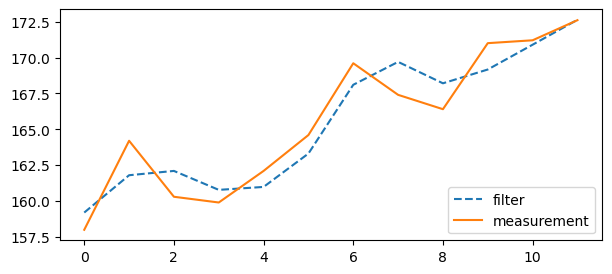

In [87]:
plot_g_h_results(weights, filtered)

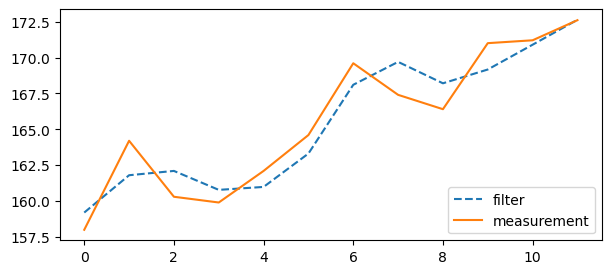

In [86]:
plot_g_h_results(weights, filtered_jax)